<a href="https://www.kaggle.com/code/stefandudley/airline-loyal-program-analysis?scriptVersionId=248559913" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# WORK IN PROGRESS

# Airline Loyal Program Analysis

### The purpose of this analysis is to address the following questions:

#### 1. What impact did the campaign have on program memberships (gross / net)?

#### 2. Was the campaign adoption more successful for certain demographics of loyalty members?

#### 3. What impact did the campaign have on booked flights during summer?

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Exploratory Analysis / Data Cleaning
The structure of the datasets was observed to determine how to prepare the datasets to address the business tasks.

The dataset was primarily focused on Customer Lifetime Value (CLV), which was calculated by the total invoice value for all the flights the member booked, and the Enrollment Type, where customers were either enrolled in the standard or the 2018 promotion program.

To clean the dataset for calculations and visualizations, the analysis conducted the following steps:
* Merged the flight activity and loyalty history datasets by Loyalty Number.
* Renamed variables for consistency.
* Concatenated month and year into a string to form the Enrollment Date and Cancellation Date columns.
* Imputed NA and NaT for missing values in Cancellation Date so that people who are still enrolled are accounted for.

In [2]:
loyalty = pd.read_csv("/kaggle/input/airline-loyalty-program/Customer Loyalty History.csv")
flights = pd.read_csv("/kaggle/input/airline-loyalty-program/Customer Flight Activity.csv")

print(f'Loyalty: {loyalty.info()}')
print(f'Flights: {flights.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

In [3]:
members = loyalty.drop_duplicates(subset = 'Loyalty Number').copy()

# Create Enrollmeent Period Date
members['Enroll Period'] = pd.to_datetime({
    'year': members['Enrollment Year'].astype(int),
    'month': members['Enrollment Month'].astype(int),
    'day': 1
})

# Create Cancel Period Date
members['Cancel Period'] = pd.to_datetime({
    'year': members['Cancellation Year'].fillna(0).astype(int),
    'month': members['Cancellation Month'].fillna(1).astype(int),
    'day': 1
}, errors='coerce')

print(f'Members: {members.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Loyalty Number      16737 non-null  int64         
 1   Country             16737 non-null  object        
 2   Province            16737 non-null  object        
 3   City                16737 non-null  object        
 4   Postal Code         16737 non-null  object        
 5   Gender              16737 non-null  object        
 6   Education           16737 non-null  object        
 7   Salary              12499 non-null  float64       
 8   Marital Status      16737 non-null  object        
 9   Loyalty Card        16737 non-null  object        
 10  CLV                 16737 non-null  float64       
 11  Enrollment Type     16737 non-null  object        
 12  Enrollment Year     16737 non-null  int64         
 13  Enrollment Month    16737 non-null  int64     

In [4]:
# Filter for 2018
en18 = members[members['Enrollment Year'] == 2018]

# Campaign start and end date
campaign_start_end_dates = en18.groupby('Enrollment Type')['Enroll Period'].agg(['min', 'max'])

historical_start_end_dates = members.groupby('Enrollment Type')['Enroll Period'].agg(['min', 'max'])

# campaign_start_end_dates
print(f'Campaign Period: {campaign_start_end_dates}')
print(f'Dataset Range: {historical_start_end_dates}')

Campaign Period:                        min        max
Enrollment Type                      
2018 Promotion  2018-02-01 2018-04-01
Standard        2018-01-01 2018-12-01
Dataset Range:                        min        max
Enrollment Type                      
2018 Promotion  2018-02-01 2018-04-01
Standard        2012-04-01 2018-12-01


### NOTE: The promotional campaign only lasted for two months between February and April 2018 while the dataset ranges from April 2012 to December 2018.

## 1. What impact did the campaign have compared to historical data (gross / net)?
"Gross" was defined as the number of new enrollments during the campaign period while "Net" was defined as the number of new enrollments minus the number of cancellations during the campaign period. The monthly net was calculated by taking the gross enrolllment and subtracting that total from the cancellations.

The analysis compared the period where the 2018 promotion was active (i.e., February, March, and April) compared to the previous two years.

The analysis found that there was a higher net of enrollments in 2018 compared to previous years. This suggest that the promotion could have led to an increase in promotions.

In [5]:
# Filter for enrollments during campaign timeframe in 2016, 2017, and 2018 
selected_years = [2016, 2017, 2018]
enrollment_period = loyalty[
    (loyalty["Enrollment Year"].isin(selected_years)) &
    (loyalty["Enrollment Month"].between(2, 4))
]

enrollment_period.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
18,172755,Canada,Alberta,Edmonton,T3G 6Y6,Female,College,NaN,Single,Aurora,5303.76,2018 Promotion,2018,3,NaN,NaN
22,642313,Canada,Alberta,Edmonton,T9G 1W3,Male,College,NaN,Married,Star,3885.46,Standard,2016,3,NaN,NaN
36,938981,Canada,Alberta,Edmonton,T3G 6Y6,Female,College,NaN,Single,Aurora,5337.35,2018 Promotion,2018,4,NaN,NaN


In [6]:
# Group to get Gross and Net figures
gross_enrollments = enrollment_period.groupby("Enrollment Year")["Loyalty Number"].nunique().rename("Gross")
cancellations = enrollment_period[loyalty["Cancellation Year"] == loyalty["Enrollment Year"]].groupby("Enrollment Year")["Loyalty Number"].nunique().rename("Canceled")

print(f'Gross Enrollment: {gross_enrollments}')
print(f'Cancellations: {cancellations}')

Gross Enrollment: Enrollment Year
2016    603
2017    629
2018    971
Name: Gross, dtype: int64
Cancellations: Enrollment Year
2016     67
2017     76
2018    115
Name: Canceled, dtype: int64


/tmp/ipykernel_13/3749330082.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cancellations = enrollment_period[loyalty["Cancellation Year"] == loyalty["Enrollment Year"]].groupby("Enrollment Year")["Loyalty Number"].nunique().rename("Canceled")


In [7]:
net_enrollments = pd.concat([gross_enrollments, cancellations], axis=1).fillna(0).astype(int)
net_enrollments["Net"] = net_enrollments["Gross"] - net_enrollments["Canceled"]

print(f'Net by Year: {net_enrollments}')

Net by Year:                  Gross  Canceled  Net
Enrollment Year                      
2016               603        67  536
2017               629        76  553
2018               971       115  856


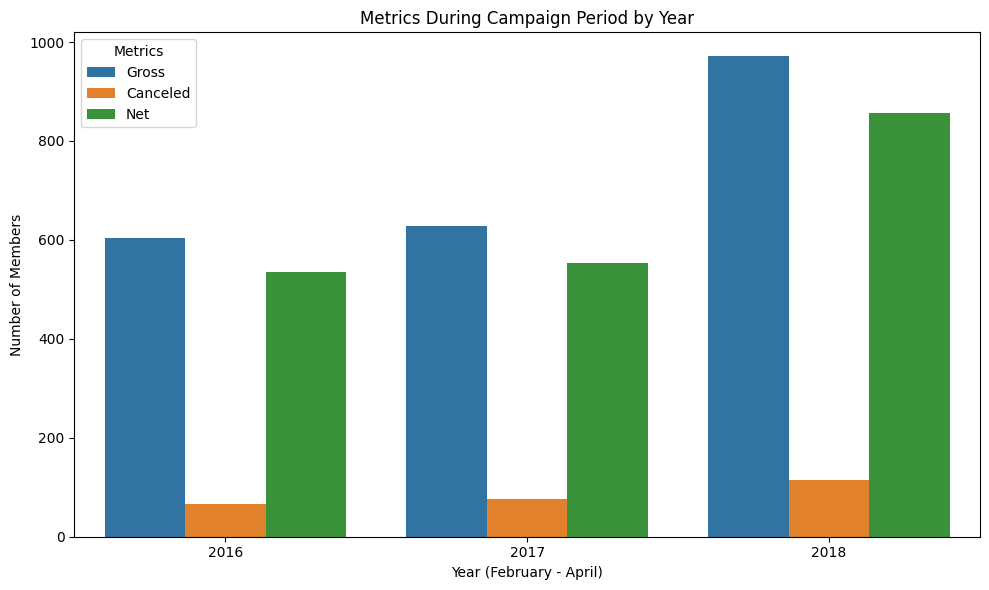

In [8]:
net_enrollments_plot = net_enrollments.reset_index().melt(id_vars="Enrollment Year", var_name="Metric", value_name="Count")

# Create grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=net_enrollments_plot, x="Enrollment Year", y="Count", hue="Metric")
plt.title("Metrics During Campaign Period by Year")
plt.ylabel("Number of Members")
plt.xlabel("Year (February - April)")
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

In [9]:
# Create Gross, Cancel, and Net Table
impact18 = pd.concat([
    enrollment_period.groupby('Enrollment Type')['Loyalty Number'].nunique().rename('Gross'),
    enrollment_period[enrollment_period['Cancellation Year'] == 2018].groupby('Enrollment Type')['Loyalty Number'].nunique().rename('Canceled')
    ], axis = 1).fillna(0).astype(int)


impact18['Net'] = impact18['Gross'] - impact18['Canceled']
impact18

,Gross,Canceled,Net
Enrollment Type,,,
2018 Promotion,971,115,856
Standard,1232,33,1199


## 2. Was the campaign adoption more successful for certain demographics of loyalty members?
CLV was compared between the standard and 2018 promotion types by gender, education, marital status, and loyalty card type.

There was a high level of kurtosis in the dataset, suggesting that outliers may be skewing the interpretation of the results.

In [10]:
# Compare CLV mean and count by demographic
def clv_pivot(df, col):
    pivot_table = df.groupby([col,'Enrollment Type']).agg(
        MeanCLV=('CLV','mean'),
        Count=('Loyalty Number','nunique')
    ).unstack(fill_value=0)
    pivot_table.columns = [f'{agg}_{etype}' for agg,etype in pivot_table.columns]
    return pivot_table

demo_cols = ['Gender','Education','Marital Status','Loyalty Card']
pivots = {c: clv_pivot(members, c) for c in demo_cols}
pivots['Gender']

,MeanCLV_2018 Promotion,MeanCLV_Standard,Count_2018 Promotion,Count_Standard
Gender,,,,
Female,8047.229130,7978.432981,494,7916
Male,8045.766499,7992.321532,477,7850


In [11]:
# Create campaign flag
loyalty["EnrollDate"] = pd.to_datetime({
    "year": loyalty["Enrollment Year"],
    "month": loyalty["Enrollment Month"],
    "day": 1
})
loyalty["CampaignMember"] = loyalty["EnrollDate"].between("2018-02-01", "2018-04-30")

# Filter for campaign members
campaign = loyalty[loyalty["CampaignMember"] == True].dropna(subset=["Enrollment Type", "Enrollment Type"])

# Sort provinces by descending total campaign members
province_totals = campaign["Province"].value_counts().sort_values(ascending=False)
province_order = province_totals.index.tolist()

# Group and compute proportions
grouped = campaign.groupby(["Province", "Loyalty Card"]).size().unstack(fill_value=0).reindex(index=province_order)
province_widths = grouped.sum(axis=1) / grouped.sum().sum()
proportions = grouped.div(grouped.sum(axis=1), axis=0)
x_positions = province_widths.cumsum() - province_widths / 2

# Create figure
fig = go.Figure()
cumulative_base = pd.Series(0, index=province_order)

for card in grouped.columns:
    height = proportions[card]
    absolute = grouped[card]
    share_percent = (height * 100).round(1).astype(str) + '%'

    customdata = list(zip(height.index, [card]*len(height), absolute, share_percent))

    fig.add_trace(go.Bar(
        x=x_positions,
        y=height,
        width=province_widths,
        base=cumulative_base,
        name=card,
        customdata=customdata,
        hovertemplate="<b>%{customdata[0]}</b><br>Card: %{customdata[1]}<br>Members: %{customdata[2]}<br>Share of Province: %{customdata[3]}<extra></extra>"
    ))
    cumulative_base += height

# Add total labels above columns
for x, province in zip(x_positions, province_order):
    total = grouped.loc[province].sum()
    fig.add_annotation(
        x=x,
        y=1.05,
        text=f"<b>{total}</b>",
        showarrow=False,
        font=dict(size=11),
        yanchor="bottom"
    )

# Loyalty card totals to the right
card_totals = grouped.sum()
y_pos = 1.05
for card, total in card_totals.items():
    fig.add_annotation(
        x=1.01,
        y=y_pos,
        text=f"<b>{card}: {total}</b>",
        showarrow=False,
        xanchor="left",
        font=dict(size=11)
    )
    y_pos -= 0.08

# Adjust layout
fig.update_layout(
    barmode='stack',
    title={
        'text': 'Loyalty Card Distribution During Promotion by Province',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=x_positions,
        ticktext=province_order,
        title='Province',
        tickangle=60
    ),
    yaxis=dict(
        title='Proportion',
        tickformat=".0%",
        range=[0, 1.15]
    ),
    margin=dict(l=40, r=140, t=100, b=100),
    showlegend=True
)

fig.show()

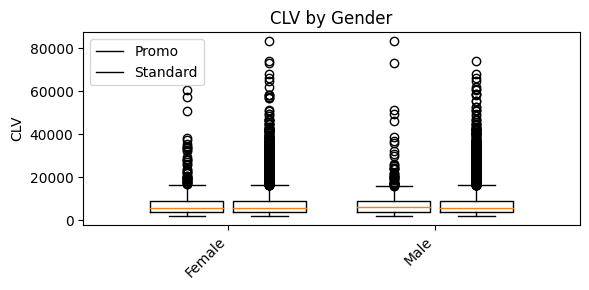

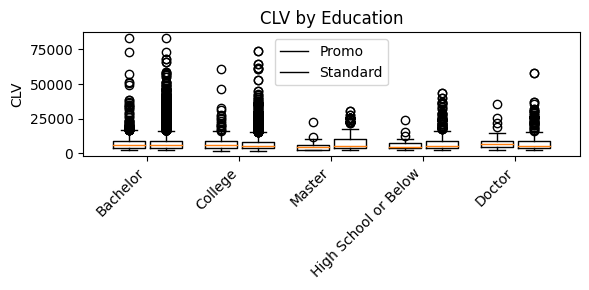

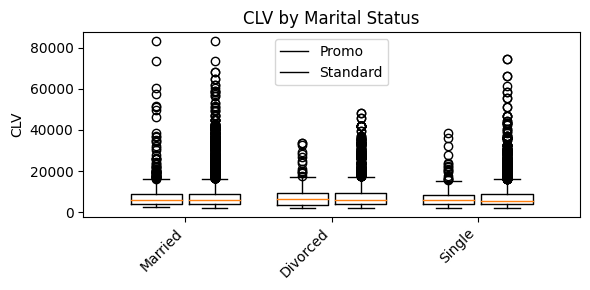

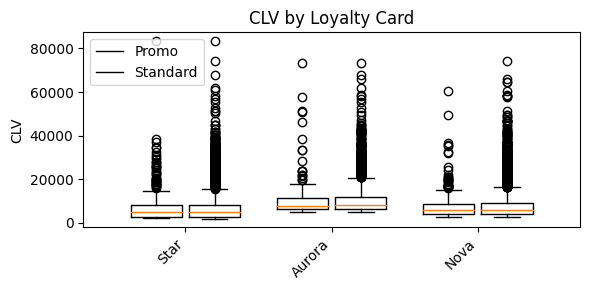

In [12]:
# Bxplots for each demoprahic
for demo in demo_cols:
    cats = members[demo].unique()
    promo = [members[(members[demo] == cat) & (members['Enrollment Type'] == '2018 Promotion')]['CLV'] for cat in cats]
    standard = [members[(members[demo] == cat) & (members['Enrollment Type'] == 'Standard')]['CLV'] for cat in cats]
    fig, ax = plt.subplots(figsize = (6,3))
    ax.boxplot(promo, positions = np.arange(len(cats)), widths = 0.35)
    ax.boxplot(standard, positions = np.arange(len(cats)) + 0.4, widths = 0.35)
    ax.set_xticks(np.arange(len(cats)) + 0.2)
    ax.set_xticklabels(cats, rotation = 45, ha = 'right')
    ax.set_ylabel('CLV')
    ax.set_title(f'CLV by {demo}')
    ax.legend(['Promo','Standard'])
    plt.tight_layout()
    plt.show()

## 3. What impact did the campaign have on booked flights during summer?

Members who enrolled during the campaign period tended to fly more and travelled farther than previous years.


In [13]:
summer = flights.merge(
    members[['Loyalty Number','Enrollment Type','Enroll Period']],
    on='Loyalty Number',
    how='left'
)

# build a “first-of-month” date for each flight
summer['FlightPeriod'] = pd.to_datetime({
    'year':  summer['Year'].astype(int),
    'month': summer['Month'].astype(int),
    'day':   1
})

# filter Jun–Aug 2018 AND flights on/after enrollment
mask = (
    summer['FlightPeriod'].dt.to_period('M').isin(pd.period_range('2018-06','2018-08',freq='M'))
    & (summer['FlightPeriod'] >= summer['Enroll Period'])
)
summer_act = summer.loc[mask].copy()

# Summer Enrollment Totals
member_summer = (
    summer_act
    .groupby(['Enrollment Type','Loyalty Number'])
    .agg(
        TotalFlights  = ('Total Flights','sum'),
        TotalDistance = ('Distance','sum'),
        PointsAccumulated = ('Points Accumulated', 'sum'),
        PointsRedeemed = ('Points Accumulated', 'sum'),
        DollarCostPointsRedeemed =('Dollar Cost Points Redeemed','sum')
    )
    .reset_index()
)

# Roll up to cohort
impact_summer = (
    member_summer
    .groupby('Enrollment Type')
    .agg(
        AvgFlightsPerMember  = ('TotalFlights','mean'),
        AvgPointsAccumalted = ('PointsAccumulated', 'mean'),
        AvgPointsRedeemed = ('PointsAccumulated', 'mean'),
        AvgDollarCostPointsRedeemed =('DollarCostPointsRedeemed','mean'),
        AvgDistancePerMember = ('TotalDistance','mean'),
        MemberCount          = ('Loyalty Number','nunique')
    )
    .round(2)
)

impact_summer

,AvgFlightsPerMember,AvgPointsAccumalted,AvgPointsRedeemed,AvgDollarCostPointsRedeemed,AvgDistancePerMember,MemberCount
Enrollment Type,,,,,,
2018 Promotion,24.76,55579.88,55579.88,23.89,37053.25,971
Standard,5.36,8051.90,8051.90,22.65,8051.90,14884


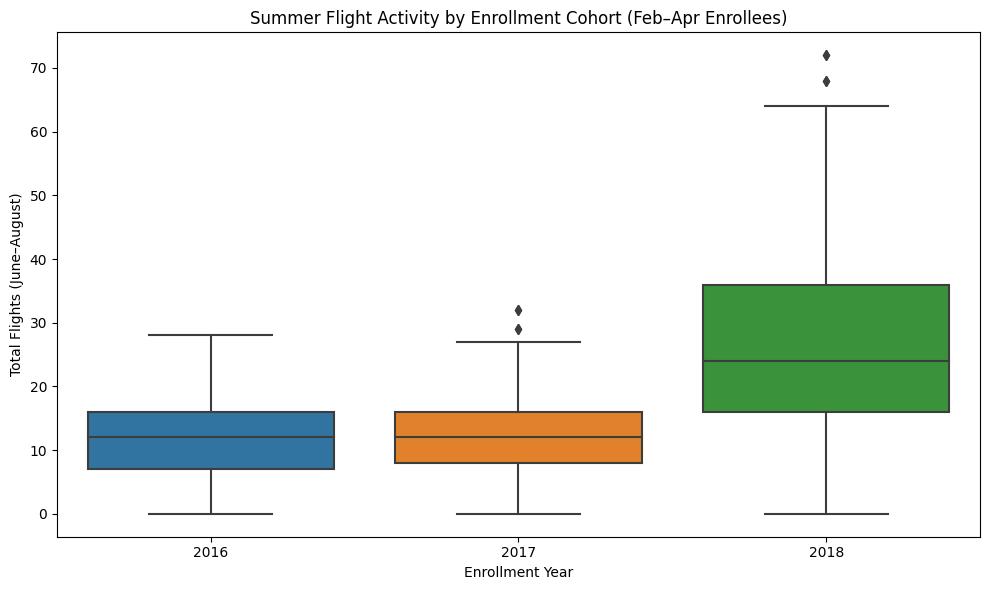

In [14]:
cohorts = loyalty[
    loyalty["Enrollment Year"].isin([2016, 2017, 2018]) &
    loyalty["Enrollment Month"].between(2, 4)
][["Loyalty Number", "Enrollment Year"]].rename(columns={"Enrollment Year": "CohortYear"})

# Prepare summer flight activity (June–August)
summer_flights = flights[flights["Month"].isin([6, 7, 8])]

# Aggregate total flights per member
summer_agg = summer_flights.groupby("Loyalty Number")["Total Flights"].sum().reset_index()
summer_agg = summer_agg.merge(cohorts, on="Loyalty Number", how="inner")

# Visualize with boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=summer_agg, x="CohortYear", y="Total Flights")
plt.title("Summer Flight Activity by Enrollment Cohort (Feb–Apr Enrollees)")
plt.ylabel("Total Flights (June–August)")
plt.xlabel("Enrollment Year")
plt.tight_layout()
plt.show()

In [15]:
# Prepare samples
flights_2016 = summer_agg[summer_agg["CohortYear"] == 2016]["Total Flights"]
flights_2017 = summer_agg[summer_agg["CohortYear"] == 2017]["Total Flights"]
flights_2018 = summer_agg[summer_agg["CohortYear"] == 2018]["Total Flights"]

# Perform t-tests
t_16_vs_18 = ttest_ind(flights_2016, flights_2018, equal_var=False)
t_17_vs_18 = ttest_ind(flights_2017, flights_2018, equal_var=False)
t_16_vs_17 = ttest_ind(flights_2016, flights_2017, equal_var=False)

{
    "T-test: 2016 vs 2018 (p-value)": t_16_vs_18.pvalue,
    "T-test: 2017 vs 2018 (p-value)": t_17_vs_18.pvalue,
    "T-test: 2016 vs 2017 (p-value)": t_16_vs_17.pvalue,
    "Mean Flights 2016": flights_2016.mean().round(2),
    "Mean Flights 2017": flights_2017.mean().round(2),
    "Mean Flights 2018": flights_2018.mean().round(2)
}

{'T-test: 2016 vs 2018 (p-value)': 3.4840644438096215e-107,
 'T-test: 2017 vs 2018 (p-value)': 1.4947402000493487e-101,
 'T-test: 2016 vs 2017 (p-value)': 0.05539658789668578,
 'Mean Flights 2016': 11.19,
 'Mean Flights 2017': 11.88,
 'Mean Flights 2018': 24.76}

## Conclusion and Recommendations

1. There was a significant increase in the number of enrollments during the campaign period, where customers who enrolled during that time tended to fly more miles and take more flights.

2. The analysis recommends that the airline finds incentives to convert Star and Nova loyalty card members to become Aurura loyalty members since the average customer lifetime value is approximately $3000 CAD more for Aurora level members. The analysis also recommends focusing on Ontario, British Columbia, and Quebec due to the higher number of customers in those regions.

3. The mean number of summer flights in 2018 was higher than 2016 and 2017, which suggests that the campaign may have increased enrollments. In addition, the mean flights per member, mean points accumalted, mean points redeemed, and mean distance per member in the 2018 promotional group were higher than the standard group.

### In conclusion, the 2018 promotional campaign was successful; however further clarification is needed to remove outliers and improve the accuracy of the study.